In [43]:
%pip install pandas xgboost scikit-learn numpy matplotlib --no-cache-dir

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 24.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 28.9 MB/s eta 0:00:00

[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [13]:
import pandas as pd

df_1 = pd.read_csv("hist_india_vix_-01-01-2023-to-01-01-2024.csv")
df_2 = pd.read_csv("hist_india_vix_-02-01-2024-to-01-01-2025.csv")
df_3 = pd.concat([df_1,df_2])



In [14]:
len(df_3)

495

In [18]:
df_3.to_csv("sample_dataset_23-25.csv")

In [19]:
df = pd.read_csv("sample_dataset_23-25.csv")

In [23]:
df.head()
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 495 entries, 0 to 494
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    495 non-null    int64  
 1   Date          495 non-null    object 
 2   Open          495 non-null    float64
 3   High          495 non-null    float64
 4   Low           495 non-null    float64
 5   Close         495 non-null    float64
 6   Prev. Close   495 non-null    float64
 7   Change        495 non-null    float64
 8   % Change      495 non-null    float64
dtypes: float64(7), int64(1), object(1)
memory usage: 34.9+ KB


,Unnamed: 0,Open,High,Low,Close,Prev. Close,Change,% Change
count,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000
mean,123.250505,13.562354,14.190242,12.644232,13.562116,13.562354,-0.000162,0.132545
std,71.519666,2.384558,2.686645,2.203653,2.384533,2.384558,0.830192,5.237653
min,0.000000,10.135000,10.702500,8.182500,10.135000,10.135000,-7.860000,-29.400000
25%,61.500000,11.812500,12.252500,11.073750,11.812500,11.812500,-0.350000,-2.540000
50%,123.000000,13.250000,13.815000,12.340000,13.250000,13.250000,-0.030000,-0.230000
75%,185.000000,14.588750,15.370000,13.812500,14.583750,14.588750,0.330000,2.585000
max,247.000000,26.747500,31.710000,23.545000,26.747500,26.747500,6.050000,42.230000


In [25]:
df['Date '] = pd.to_datetime(df['Date '], format='%d-%b-%Y')
df = df.sort_values('Date ')
df = df.reset_index(drop=True)


In [27]:
df.head()
df.columns=df.columns.str.strip()

In [28]:
df['Overnight_NIFTY_Change'] = (df['Open'] - df['Prev. Close'].shift(1)) / df['Prev. Close'].shift(1) * 100

In [30]:
print(df[['Date', 'Open', 'Close', 'Overnight_NIFTY_Change']].head(10))
df = df.dropna(subset=['Overnight_NIFTY_Change'])


        Date     Open    Close  Overnight_NIFTY_Change
0 2023-01-02  14.8675  14.6850                     NaN
1 2023-01-03  14.6850  14.3850               -1.227510
2 2023-01-04  14.3850  15.1975               -2.042901
3 2023-01-05  15.1975  14.9825                5.648245
4 2023-01-06  14.9825  15.0250               -1.414706
5 2023-01-09  15.0250  14.6525                0.283664
6 2023-01-10  14.6525  15.5100               -2.479201
7 2023-01-11  15.5100  15.4350                5.852244
8 2023-01-12  15.4350  15.2750               -0.483559
9 2023-01-13  15.2750  14.4600               -1.036605


Prepare data for modelling

In [31]:
# Define features and target
features = ['Open', 'High', 'Low', 'Prev. Close', 'Overnight_NIFTY_Change']
target = 'Close'

X = df[features]
y = df[target]


In [32]:
train_size = int(len(df) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]


In [39]:
from sklearn.preprocessing import MinMaxScaler

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1,1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1,1))


In [40]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

model = XGBRegressor(n_estimators=100, learning_rate=0.05)
model.fit(X_train_scaled, y_train_scaled.ravel())

y_pred_scaled = model.predict(X_test_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1,1))


In [41]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", rmse)


RMSE: 0.7596310487819413


In [45]:
X.tail(1)

,Open,High,Low,Prev. Close,Overnight_NIFTY_Change
494,14.4475,14.835,14.305,14.4475,3.399535


In [42]:
last_features = X.tail(1)
last_scaled = scaler_X.transform(last_features)
next_day_pred_scaled = model.predict(last_scaled)
next_day_pred = scaler_y.inverse_transform(next_day_pred_scaled.reshape(-1,1))
print("Predicted Next Day Close:", next_day_pred[0][0])


Predicted Next Day Close: 14.34171


Matplotlib is building the font cache; this may take a moment.


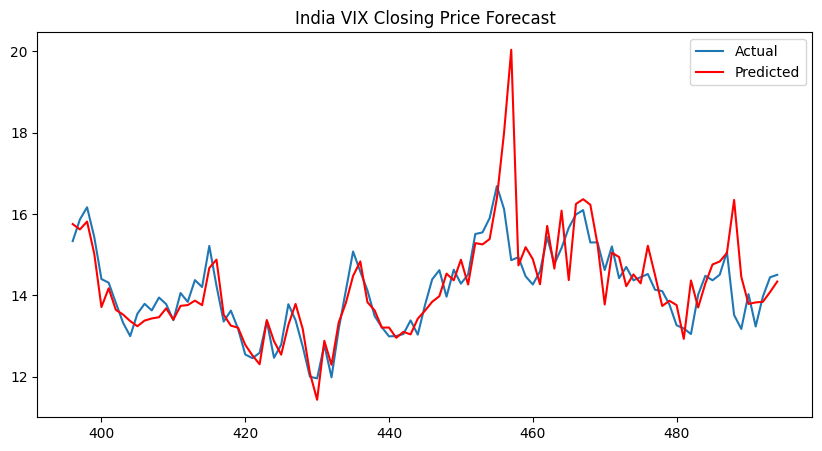

In [44]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(y_test.index, y_test.values, label='Actual')
plt.plot(y_test.index, y_pred, label='Predicted', color='red')
plt.title('India VIX Closing Price Forecast')
plt.legend()
plt.show()


In [46]:
import joblib

# Save model
joblib.dump(model, 'india_vix_forecast_model.pkl')

# Save scalers (since you used MinMaxScaler)
joblib.dump(scaler_X, 'scaler_X.pkl')
joblib.dump(scaler_y, 'scaler_y.pkl')

print("✅ Model and scalers saved successfully.")


✅ Model and scalers saved successfully.


In [50]:
model = joblib.load('india_vix_forecast_model.pkl')
scaler_X = joblib.load('scaler_X.pkl')
scaler_y = joblib.load('scaler_y.pkl')

sample_input = X.head(1)
new_data_scaled = scaler_X.transform(sample_input)

pred_scaled = model.predict(new_data_scaled)
predicted_close = scaler_y.inverse_transform(pred_scaled.reshape(-1, 1))
print("Predicted Next Day Close:", round(predicted_close[0][0], 4))


Predicted Next Day Close: 14.5018


In [51]:
def predict_next_day_close(open_price, high_price, low_price, prev_close):
    model = joblib.load('india_vix_forecast_model.pkl')
    scaler_X = joblib.load('scaler_X.pkl')
    scaler_y = joblib.load('scaler_y.pkl')

    overnight_change = (open_price - prev_close) / prev_close * 100

    new_df = pd.DataFrame([{
        'Open': open_price,
        'High': high_price,
        'Low': low_price,
        'Prev. Close': prev_close,
        'Overnight_NIFTY_Change': overnight_change
    }])

    new_scaled = scaler_X.transform(new_df)
    pred_scaled = model.predict(new_scaled)
    predicted_close = scaler_y.inverse_transform(pred_scaled.reshape(-1,1))

    return float(predicted_close[0][0])


In [52]:
next_close = predict_next_day_close(15.1200, 15.5000, 14.9500, 15.0250)
print("Predicted Close for Next Day:", round(next_close, 4))


Predicted Close for Next Day: 15.0434
